# Random Forest

## Load Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 

In [2]:
n = 100
d = 2
ranges = 1.5
postives = np.random.randn(n, d) + np.array([ranges, -ranges])
negatives = np.random.randn(n, d) + np.array([-ranges, ranges])

postives = np.round(postives)
negatives = np.round(negatives)

postives = np.column_stack((postives, np.ones(n)))
negatives = np.column_stack((negatives, np.zeros(n)))

def split_dataset(X,y, test_size = 0.2):
    '''
    Split the dataset into training and testing set.
    '''
    n = X.shape[0]
    n_test = int(n*test_size)
    n_train = n - n_test
    mask = np.random.permutation(n)
    X = X[mask]
    y = y[mask]
    X_train = X[:n_train]
    y_train = y[:n_train]
    X_test = X[n_train:]
    y_test = y[n_train:]
    return X_train, X_test, y_train, y_test

data = np.vstack((postives, negatives))
np.random.shuffle(data)
X, y = data[:, :-1], data[:, -1]

# train_size = int(2*n*0.8)
# X_train = X[:train_size]
# y_train = y[:train_size]
# X_test = X[train_size:]
# y_test = y[train_size:]

X_train, X_test, y_train, y_test = split_dataset(X, y, 0.2)

print(f'{X_train.shape = }\n{X_test.shape = }\n{y_train.shape = }\n{y_test.shape = }\n')

X_train.shape = (160, 2)
X_test.shape = (40, 2)
y_train.shape = (160,)
y_test.shape = (40,)



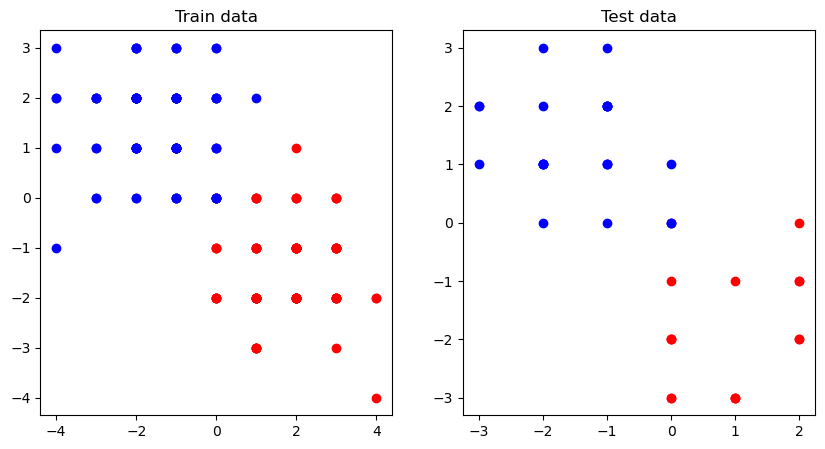

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
_ = axes[0].scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='red')
_ = axes[0].scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color='blue')
_ = axes[0].set_title('Train data')
_ = axes[1].scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color='red')
_ = axes[1].scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color='blue')
_ = axes[1].set_title('Test data')


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

random_forest_builtin = RandomForestClassifier()
random_forest_builtin.fit(X_train, y_train)

y_pred = random_forest_builtin.predict(X_test) 
print(f'Acc : {accuracy_score(y_pred, y_test):.2%}')

RandomForestClassifier()

Acc : 97.50%


## Custom implementation to solve RForest

check `BAGGING` code at https://github.com/Mahanth-Maha/BasicML/blob/main/MahaML/ensembleBaggingClassification.py

In [5]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

In [6]:
class DecisionTree_Classifier:
    def __init__(self, method = 'entropy', depth_threshold=None, min_samples_split=2):
        self.depth_threshold = depth_threshold or 1000
        self.min_samples_split = min_samples_split
        self.root = None
        self.method = method
        
    def _entropy(self, y):
        m = len(y)
        if m == 0:
            return 0
        classes, counts = np.unique(y, return_counts=True)
        probs = counts / m
        log_probs = np.log(probs)
        p_log_p = probs * log_probs
        return -1 * np.sum(p_log_p)
    
    def _gini(self, y):
        m = len(y)
        if m == 0:
            return 0
        classes, counts = np.unique(y, return_counts=True)
        probs = counts / m
        return 1 - np.sum(probs ** 2)
    
    def _best_split(self, X, y):
        m, n = X.shape
        best_info_gain = float('-inf')
        best_idx, best_thr = None, None

        if m >= self.min_samples_split:
            for idx in range(n):
                all_y_vals = np.unique(X[:, idx])
                for yi in all_y_vals:
                    left_mask = X[:, idx] <= yi
                    right_mask = X[:, idx] > yi
                    if left_mask.sum() == 0 or right_mask.sum() == 0:
                        continue
                    if self.method == 'entropy':
                        info_gain_left = self._entropy(y[left_mask])
                        info_gain_right = self._entropy(y[right_mask])
                    elif self.method == 'gini':
                        info_gain_left = self._gini(y[left_mask])
                        info_gain_right = self._gini(y[right_mask])
                    
                    info_gain = -1 * (left_mask.sum() * info_gain_left + right_mask.sum() * info_gain_right) / m

                    if info_gain > best_info_gain:
                        best_info_gain = info_gain
                        best_idx = idx
                        best_thr = yi

        return best_idx, best_thr

    def _grow_tree(self, X, y, depth):
        num_samples_per_class = [np.sum(y == c) for c in np.unique(y)]
        majority_class = np.unique(y)[np.argmax(num_samples_per_class)]
        
        if (depth >= self.depth_threshold or len(np.unique(y)) == 1 or len(y) < self.min_samples_split):
            return Node(value = majority_class)

        idx, thr = self._best_split(X, y)
        
        if idx is None:
            return Node(value = majority_class)

        left_mask = X[:, idx] <= thr
        right_mask =  X[:, idx] > thr
        left = self._grow_tree(X[left_mask], y[left_mask], depth + 1)
        right = self._grow_tree(X[right_mask], y[right_mask], depth + 1)
        
        return Node(idx, thr, left, right)

    def _predict(self, inputs, node):
        if node.value is not None:
            return node.value
        if inputs[node.feature] <= node.threshold:
            return self._predict(inputs, node.left)
        return self._predict(inputs, node.right)
    
    def fit(self, X, y):
        self.root = self._grow_tree(X, y, depth=0)

    def predict(self, X):
        return np.array([self._predict(inputs, self.root) for inputs in X])

    def acc_score(self, y_true, y_pred):
        return np.mean(y_true == y_pred)

    def plot(self, X_train, y_train, X_test = None, y_test = None):
        plt.figure(figsize=(10, 8))
        plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='red' , alpha=0.5, label='Train -ve')
        plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color='blue' , alpha=0.5 , label='Train +ve')

        if X_test is not None and y_test is not None:
            plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color='red', marker='x' , alpha=0.9 , label='Test -ve')
            plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color='blue', marker='x', alpha=0.9, label='Test +ve')

        plt.legend()
        plt.show()

In [7]:
class RandomizedDecisionTree_Classifier(DecisionTree_Classifier):
    def __init__(self, method='entropy', depth_threshold=None, min_samples_split=2, k_features=None):
        super().__init__(method=method, depth_threshold=depth_threshold, min_samples_split=min_samples_split)
        self.k_features = k_features 

    def _best_split(self, X, y):
        m, n = X.shape
        best_info_gain = float('-inf')
        best_idx, best_thr = None, None

        if self.k_features is None or self.k_features > n:
            feature_indices = np.arange(n)
        else:
            feature_indices = np.random.choice(n, self.k_features, replace=False)

        if m >= self.min_samples_split:
            for idx in feature_indices:
                thresholds = np.unique(X[:, idx])
                for thr in thresholds:
                    left_mask = X[:, idx] <= thr
                    right_mask = X[:, idx] > thr
                    if left_mask.sum() == 0 or right_mask.sum() == 0:
                        continue
                    if self.method == 'entropy':
                        left_impurity = self._entropy(y[left_mask])
                        right_impurity = self._entropy(y[right_mask])
                    elif self.method == 'gini':
                        left_impurity = self._gini(y[left_mask])
                        right_impurity = self._gini(y[right_mask])
                    else:
                        raise ValueError(f"Unknown method: {self.method}")
                    
                    info_gain = -1 * (left_mask.sum() * left_impurity + right_mask.sum() * right_impurity) / m

                    if info_gain > best_info_gain:
                        best_info_gain = info_gain
                        best_idx = idx
                        best_thr = thr

        return best_idx, best_thr

In [8]:
class LogisticRegression_Classifier:
    def __init__(self , alpha = 0.01 , max_iter = 1000 , stochastic = False , stochastic_choice = -1, epsilon = 1e-5):
        # stochastic = True => mini batch gradient descent with batch_size =  stochastic_choice
        self.lr = alpha
        self.max_iter = max_iter
        self.stochastic = stochastic
        self.stochastic_choice = stochastic_choice
        self.epsilon = epsilon

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.n, self.m = X.shape
        self.classes = np.unique(y)
        if self.stochastic :
            if 0 < self.stochastic_choice < self.n:
                self.mini_batch = self.stochastic_choice
            else :
                self.mini_batch = np.random.randint(1,self.n)
        else :
            self.mini_batch = self.n
        self.w = np.random.randn(self.m) + 0.5
        self.b = np.random.randn()
        self.losses = []
        for i in range(self.max_iter):
            w_prev = self.w.copy()
            self.update_weights()
            self.losses.append(self.loss())
            if np.linalg.norm(w_prev - self.w) < self.epsilon:
                print(f'Converged at {i} iteration')
                break
        return self.losses
    
    def update_weights(self):
        dw = np.zeros(self.m)
        db = 0
        indices = np.random.choice(self.n, self.mini_batch, replace=False)
        for i in indices:
            y_pred = self.sigmoid(np.dot(self.w, self.X_train[i]) + self.b)
            dw += (y_pred - self.y_train[i]) * self.X_train[i]
            db += (y_pred - self.y_train[i])
        if self.lr > 0.001:
            self.lr = self.lr * 0.99
        self.w -= self.lr * dw
        self.b -= self.lr * db

    def predict(self,X):
        y = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            if self.classes.shape[0] > 2:
                y[i] = np.argmax(self.softmax(np.dot(self.w,X[i]) + self.b))
            else:
                y[i] = 1 if self.sigmoid(np.dot(self.w,X[i]) + self.b) > 0.5 else 0
        return y

    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    def softmax(self, x):
        return np.exp(x) / np.sum(np.exp(x), axis=0) 

    def loss(self):
        epsilon = 1e-15 
        loss = 0
        for i in range(self.n):
            if self.classes.shape[0] > 2:
                y_pred = self.softmax(np.dot(self.w, self.X_train[i]) + self.b)
                loss += -np.log(y_pred[self.y_train[i]])
            else:
                y_pred = self.sigmoid(np.dot(self.w, self.X_train[i]) + self.b)
                y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
                loss += self.y_train[i] * np.log(y_pred) + (1 - self.y_train[i]) * np.log(1 - y_pred)
        return -loss/self.n

    def acc_score(self, y_true, y_pred):
        return np.mean(y_true == y_pred)
    
    def plot(self):
        plt.plot(self.losses)
        plt.xlabel('max_iter')
        plt.ylabel('Loss')
        plt.show()

In [9]:
class EnsembleBaggingClassification:
    def __init__(self, base_model = 'dtree', m_models = 10, sample_ratio = 0.5, method = 'entropy', depth_threshold=5, min_samples_split=2, use_lr_agg = False, alpha = 0.01 , max_iter = 1000 , stochastic = False , stochastic_choice = -1, epsilon = 1e-5):
        self.m_models = m_models 
        self.base_model = base_model
        self.use_lr_agg  = use_lr_agg 
        self.sample_ratio = sample_ratio
        if self.base_model == 'dtree':
            self.models = [ DecisionTree_Classifier(method, depth_threshold, min_samples_split) for _ in range(self.m_models) ]
        elif self.base_model == 'rdtree':
            self.models = [ RandomizedDecisionTree_Classifier(method, depth_threshold, min_samples_split) for _ in range(self.m_models) ]
        else: 
            self.models = [ DecisionTree_Classifier(method, depth_threshold, min_samples_split) for _ in range(self.m_models) ]
            
        self.data_sampled = None
        self.aggregator = LogisticRegression_Classifier(alpha, max_iter, stochastic, stochastic_choice, epsilon) if self.use_lr_agg else None
    
    
    def _sample_datapoints(self, X, y, split=0.5):
        n_samples = int(X.shape[0] * split)
        all_indices = np.arange(X.shape[0])
        
        in_bag_indices = np.random.choice(all_indices, size=n_samples, replace=True)
        
        out_of_bag_mask = np.ones(X.shape[0], dtype=bool)
        out_of_bag_mask[in_bag_indices] = False
        out_of_bag_indices = all_indices[out_of_bag_mask]

        self.data_sampled[in_bag_indices] += 1
        
        return X[in_bag_indices], y[in_bag_indices], in_bag_indices, out_of_bag_indices

    

    def fit(self, X, y, store_test_samples=True, report_true_test_error=False, verbose = False):
        self.data_sampled = np.zeros(X.shape[0])
        y_preds = []
        self.model_inbag_indices = []     # track which samples trained each model
        self.model_oob_indices = []       # track which samples were left out (OOB)
        self.model_oob_scores = []        # optional per-model OOB accuracy
        
        y_preds_train = []
        
        for i, model in tqdm(enumerate(self.models) , desc='Training Models',unit=' Model'):
            if verbose:
                print(f"Training model {i+1}")
            
            X_i, y_i, inbag, oob = self._sample_datapoints(X, y, self.sample_ratio)
            
            self.model_inbag_indices.append(inbag)
            self.model_oob_indices.append(oob)

            model.fit(X_i, y_i)
            y_pred_train = model.predict(X_i)
            y_preds_train.append(y_pred_train)
            if verbose:
                acc_train = model.acc_score(y_i, y_pred_train)
                print(f"Model {i+1} Train accuracy: {acc_train:.2%}")
            if report_true_test_error and len(oob) > 0:
                y_pred_oob = model.predict(X[oob])
                oob_acc = np.mean(y_pred_oob == y[oob])
                self.model_oob_scores.append(oob_acc)
                if verbose:
                    print(f"Model {i+1} Test accuracy: {oob_acc:.2%}")
            y_preds.append(y_pred)
        
        if self.use_lr_agg:
            X_new = np.array(y_preds).T
            y_new = y 
            if verbose:
                print(f'Training Aggregator...')
                # print(f'{X_new.shape = }, {y_new.shape = }')
            self.aggregator.fit(X_new, y_new)
        
        if (report_true_test_error or verbose) and len(self.model_oob_scores) > 0:
            mean_oob_acc = np.mean(self.model_oob_scores)
            print(f'\n[OOB Evaluation] Mean out-of-bag accuracy: {mean_oob_acc:.3f}')
            print(f'[OOB Evaluation] Estimated generalization error: {1 - mean_oob_acc:.3f}')

        # Optionally store test samples for later analysis
        if not store_test_samples:
            self.model_oob_indices = None
        
    def predict(self, X):
        y_preds = []
        for i, model in tqdm(enumerate(self.models) , desc='Predicting',unit=' Model',):
            y_pred_i = model.predict(X)
            y_preds.append(np.array(y_pred_i))
            # print(f'{y_pred_i.shape = }')
        y_preds = np.array(y_preds)
        
        if self.use_lr_agg:
            y_pred = self.aggregator.predict(y_preds.T)
        else:
            sums = np.sum(y_preds,axis=0)
            y_pred = np.where( sums > (self.m_models//2) ,1,0)
        
        return y_pred
                        
    def report_oob_error(self, X, y):
        if self.model_oob_indices is None:
            print("[ERR] No OOB data stored. Set store_test_samples=True in fit() and retrain !")
            return None
        
        oob_accuracies = []
        for i, model in enumerate(self.models):
            oob_idx = self.model_oob_indices[i]
            if len(oob_idx) == 0:
                continue
            y_pred = model.predict(X[oob_idx])
            acc = np.mean(y_pred == y[oob_idx])
            oob_accuracies.append(acc)

        if len(oob_accuracies) == 0:
            print("[WARN] No OOB samples found for any model.")
            return None

        mean_oob_acc = np.mean(oob_accuracies)
        print(f"[OOB Evaluation] Mean out-of-bag accuracy: {mean_oob_acc:.3f}")
        print(f"[OOB Evaluation] Estimated generalization error: {1 - mean_oob_acc:.3f}")
        return mean_oob_acc


    def acc_score(self, y_true, y_pred):
        return np.mean(y_true == y_pred)

    def plot(self):
        pass

In [10]:
class RandomForestDTree_Classifier(EnsembleBaggingClassification):
    def __init__(self, base_model = 'dtree', m_models = 10, sample_ratio = 0.5, method = 'entropy', depth_threshold=5, min_samples_split=2, use_lr_agg = False, alpha = 0.01 , max_iter = 1000 , stochastic = False , stochastic_choice = -1, epsilon = 1e-5):
        super().__init__(base_model=base_model, m_models=m_models, sample_ratio=sample_ratio, method=method, depth_threshold=depth_threshold, min_samples_split=min_samples_split, use_lr_agg=use_lr_agg, alpha=alpha, max_iter=max_iter, stochastic=stochastic, stochastic_choice=stochastic_choice, epsilon=epsilon)

class RandomForest_Classifier(EnsembleBaggingClassification):
    def __init__(self, base_model = 'rdtree',  m_models=10, sample_ratio=0.5, method='gini', depth_threshold=5, min_samples_split=2, use_lr_agg=False, alpha=0.01, max_iter=1000, stochastic=False, stochastic_choice=-1, epsilon=1e-5,k_features=None):
        self.m_models = m_models
        self.sample_ratio = sample_ratio
        self.use_lr_agg = use_lr_agg
        self.base_model = base_model # fixed
        self.data_sampled = None
        self.k_features = k_features
        self.models = [
            RandomizedDecisionTree_Classifier(
                method=method,
                depth_threshold=depth_threshold,
                min_samples_split=min_samples_split,
                k_features=k_features
            ) 
            for _ in range(m_models)
        ]

        self.aggregator = LogisticRegression_Classifier(
            alpha, max_iter, stochastic, stochastic_choice, epsilon
        ) if use_lr_agg else None

    def fit(self, X, y):
        if self.k_features is None:
            k_sqrt_d = int(np.sqrt(X.shape[1]))
            for model in self.models:
                model.k_features = k_sqrt_d
        super().fit(X, y)

In [11]:
random_forest = RandomForest_Classifier()
random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test) 
print(f'\nAcc : {random_forest.acc_score(y_pred, y_test):.2%}\n\n')

Training Models: 10 Model [00:00, 851.77 Model/s]
Predicting: 10 Model [00:00, 17260.51 Model/s]


Acc : 97.50%




### Aci IMDB Dataset

In [12]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import time 
DataFolder = './data/aclImdb/'
X_train = np.load(DataFolder + 'X_train.npy') 
y_train = np.load(DataFolder + 'y_train.npy')
X_train.shape , y_train.shape

((25000, 100), (25000,))

In [13]:
X_test = np.load(DataFolder + 'X_test.npy')
y_test = np.load(DataFolder + 'y_test.npy')
X_test.shape , y_test.shape

((25000, 100), (25000,))

#### SKlearn - Random Forest

In [14]:
random_forest_builtin = RandomForestClassifier()
random_forest_builtin.fit(X_train, y_train)

RandomForestClassifier()

In [15]:
y_pred = random_forest_builtin.predict(X_test) 
print(f'Acc : {accuracy_score(y_pred, y_test):.2%}')

Acc : 71.19%


#### My Implementation - Random Forest

In [16]:
rforest = RandomForest_Classifier()
rforest.fit(X_train, y_train)

Training Models: 10 Model [11:44, 70.44s/ Model]


In [17]:
y_pred = rforest.predict(X_test) 
print(f'\nAcc : {rforest.acc_score(y_pred, y_test):.2%}\n\n')

Predicting: 10 Model [00:00, 28.19 Model/s]


Acc : 65.59%


